In [78]:
#nuclio: start-code

In [66]:
import os
import torch
from torch import nn
from torchvision import transforms
from mlrun.artifacts import get_model
import json
from PIL import Image

class ModelServer:
    def __init__(self):
        self.device = os.getenv("device")
        self.model = self.load_model(device=self.device)
        self.img_transforms = transforms.Compose([transforms.Resize(((int(os.getenv("img_dimensions"))),
                                                                      int(os.getenv("img_dimensions")))),
                                                  transforms.ToTensor(),
                                                  transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])])
        
    def load_model(self, device):
        model_file, model_spec, _ = get_model(os.getenv("model_url"), suffix='.pth')
        layer_size = model_spec.parameters['layer_size']
        model = self.prep_model(device=device, layer_size=layer_size)
        model.load_state_dict(torch.load(open(model_file, "rb")))
        model.eval()
        return model

    def prep_model(self, device, layer_size, num_classes=2):
        model_resnet50 = torch.hub.load('pytorch/vision', 'resnet50', pretrained=True)

        for name, param in model_resnet50.named_parameters():
            if "bn" not in name:
                param.requires_grad = False

        model_resnet50.fc = nn.Sequential(nn.Linear(model_resnet50.fc.in_features, layer_size),
                                          nn.ReLU(),
                                          nn.Dropout(),
                                          nn.Linear(layer_size, num_classes))

        return model_resnet50.to(device)
    
    def predict(self, context, data):
        model = self.model
        
        response = {}
        for filename in data['file_paths']:
            # 1 = dog, 0 = cat
            labels = ["cat", "dog"]
            img = Image.open(filename)
            img = self.img_transforms(img)
            img = img.unsqueeze(0)
            prediction = model(img.to(self.device))
            prediction = prediction.argmax()
            response[filename] = labels[prediction]
        return context.Response(body=json.dumps(response))
            
def init_context(context):
    context.model_server = ModelServer()
    
# env:
#     device
#     context.inputs['model'].url
    
def handler(context, event):
#     init_context(context)
    return context.model_server.predict(context, json.loads(event.body))

In [79]:
#nuclio: end-code

In [77]:
import nuclio_sdk
import logging

os.environ['model_url'] = "store://dogs-vs-cats-demo/train-model-handler_model#4c11ed35-dd30-4379-9de6-fd5e46744990"
os.environ['device'] = "cpu"
os.environ['img_dimensions'] = "224"

dog_img = "/v3io/bigdata/dogs_vs_cats_sample/dog/dog.100.jpg"
cat_img = "/v3io/bigdata/dogs_vs_cats_sample/cat/cat.1000.jpg"

logger = logging.Logger('triggering')
context = nuclio_sdk.Context(logger=logger)

payload = {'file_paths': [dog_img, cat_img]}
event = nuclio_sdk.Event(body=json.dumps(payload))
handler(context, event)

Using cache found in /igz/.cache/torch/hub/pytorch_vision_master


Response(headers={}, body='{"/v3io/bigdata/dogs_vs_cats_sample/dog/dog.100.jpg": "dog", "/v3io/bigdata/dogs_vs_cats_sample/cat/cat.1000.jpg": "cat"}', status_code=200, content_type='text/plain')

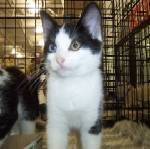

In [86]:
Image.open("/v3io/bigdata/dogs_vs_cats_sample/cat/cat.1000.jpg")